This file try to modify the periodicity, but obvious the problem originates fron the merger tree instead of the coordinates.


In [2]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
#%matplotlib widget
basePath ='./sims.TNG/TNG50-1/output'
from tqdm import tqdm
import gc
import os


In [3]:
basePath = './sims.TNG/TNG50-1/output'
initial_snapshot = 70
end_snapshot = 99

halos_fields = ['GroupFirstSub', 'GroupNsubs', 'GroupMass', 'GroupPos']
subhalos_fields = ['SubhaloGrNr', 'SubhaloMass', 'SubhaloPos']
tree_fields = ['SubfindID', 'SnapNum']


In [4]:
halos_data = il.groupcat.loadHalos(basePath, end_snapshot, fields=halos_fields)
subhalos_data = il.groupcat.loadSubhalos(basePath, end_snapshot, fields=subhalos_fields)


In [5]:
first_subhalo_indices = halos_data['GroupFirstSub']
n_subhalos = halos_data['GroupNsubs']
group_mass = halos_data['GroupMass']
subhalos_grnr = subhalos_data['SubhaloGrNr']
subhalos_mass = subhalos_data['SubhaloMass']


In [6]:
galaxy_mass_inf = 30
galaxy_mass_sup = 500
condition = (group_mass >= galaxy_mass_inf) & (group_mass <= galaxy_mass_sup)
mw_like_group_index = np.where(condition)[0]


In [7]:
def Binary_DataIter(Data_Set1,Data_Set2):
    for i in range(0,min(len(Data_Set1),len(Data_Set2))):
        yield Data_Set1[i],Data_Set2[i]


In [7]:
satellite_distances = []
is_first_approach_indices=[]


snap: 70 [-11602.594    1055.9004   4413.8506]
snap: 71 [-2271.914    9206.595     472.21973]
snap: 72 [-2652.1357   7928.332    -306.83594]
snap: 73 [-8939.588  24074.125   4904.6855]
snap: 74 [-11103.706    5623.0195  -1149.7041]
snap: 75 [-13767.386  20304.617  13884.577]
snap: 76 [-9799.295  24751.23    6609.9043]
snap: 77 [-14374.072  17430.934  13844.557]
snap: 78 [351.3838     96.65039     6.2773438]
snap: 79 [336.3423    104.625      -5.8828125]
snap: 80 [328.26318  108.171875 -13.453125]
snap: 81 [313.62988  112.62305  -25.177734]
snap: 82 [297.97705  118.3125   -35.683594]
snap: 83 [287.71387  121.958984 -42.728516]
snap: 84 [270.4082   126.78125  -52.960938]
snap: 85 [251.97266 130.33398 -63.11133]
snap: 86 [238.58398 132.23828 -69.7168 ]
snap: 87 [217.63037 134.73242 -78.91992]
snap: 88 [202.70215  135.98438  -84.109375]
snap: 89 [179.60107 136.55273 -91.70117]
snap: 90 [154.4336   135.85938  -98.228516]
snap: 91 [ 136.32178  134.61523 -102.44922]
snap: 92 [ 108.70752   131

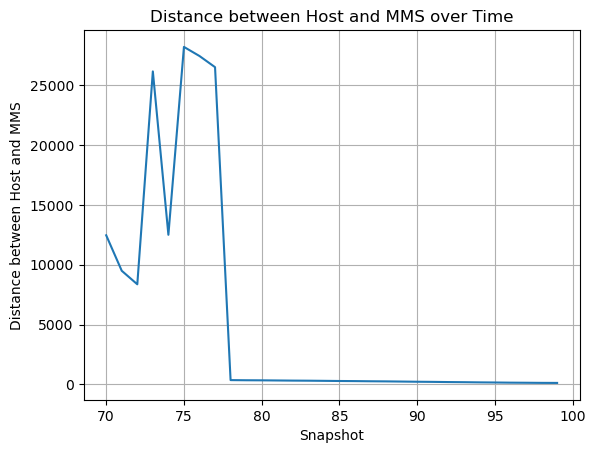

In [17]:
for halo_id in np.array([120]):
    first_subhalo_index=first_subhalo_indices[halo_id]

    if first_subhalo_index== -1:
        continue
    if n_subhalos[halo_id]==1:
        continue

    satellite_galaxies_mass_array=np.array([])

    for subhalo_id_bias in range(n_subhalos[halo_id]):
        subhalo_id=first_subhalo_index+subhalo_id_bias
        satellite_galaxies_mass_array=np.append(satellite_galaxies_mass_array,subhalos_mass[subhalo_id])

    host_id = first_subhalo_index + np.argsort(satellite_galaxies_mass_array)[-1]
    mms_id = first_subhalo_index + np.argsort(satellite_galaxies_mass_array)[-2]

    mass_host = satellite_galaxies_mass_array[np.argsort(satellite_galaxies_mass_array)[-1]]
    mass_mms = satellite_galaxies_mass_array[np.argsort(satellite_galaxies_mass_array)[-2]]

    if (mass_host/mass_mms<4): continue

    host_tree = il.sublink.loadTree(basePath, end_snapshot, host_id, fields=tree_fields)
    mms_tree = il.sublink.loadTree(basePath, end_snapshot, mms_id, fields=tree_fields)

    host_subfind_id = host_tree['SubfindID']
    mms_subfind_id = mms_tree['SubfindID']

    satellite_distances = []
    for current_snapshot in range(initial_snapshot, end_snapshot + 1):

        header=il.groupcat.loadHeader(basePath,current_snapshot)
        scale_factor=header['Time']

        current_host_id = host_subfind_id[end_snapshot-current_snapshot ]
        current_mms_id = mms_subfind_id[end_snapshot-current_snapshot]

        current_host_comoving_position = il.groupcat.loadSingle(basePath,current_snapshot,-1,current_host_id)['SubhaloPos']
        current_mms_comoving_position = il.groupcat.loadSingle(basePath,current_snapshot,-1,current_mms_id)['SubhaloPos']

        current_host_physical_position=current_host_comoving_position*scale_factor
        current_mms_physical_position=current_mms_comoving_position*scale_factor

        print('snap:',current_snapshot,current_host_physical_position-current_mms_physical_position)

        distance = np.linalg.norm(current_host_physical_position - current_mms_physical_position)


        #distance=Distance_Calculation(current_host_physical_position,current_mms_physical_position,35000)

        satellite_distances.append(distance)

    if satellite_distances and satellite_distances[-1] == min(satellite_distances):is_first_approach_indices.append(halo_id)

    snapshots = np.arange(initial_snapshot, end_snapshot + 1)
    plt.plot(snapshots, np.array(satellite_distances))
    plt.xlabel('Snapshot')
    plt.ylabel('Distance between Host and MMS')
    plt.title('Distance between Host and MMS over Time')
    plt.grid()
    fig_name = f"{halo_id}_first_approach.png"
    save_path = './FirstApp/'
    os.makedirs(save_path, exist_ok=True)
    plt.show()
    plt.savefig(os.path.join(save_path, fig_name))
    plt.close("all")


In [53]:
def Distance_Calculation(Pos1,Pos2,boxsize):
    dx=abs(Pos2[0]-Pos1[0])
    dy=abs(Pos2[1]-Pos1[1])
    dz=abs(Pos2[2]-Pos1[2])
    dx2 = abs(boxsize - dx)
    dy2 = abs(boxsize - dy)
    dz2 = abs(boxsize - dz)
    dx = min(dx,dx2)
    dy = min(dy,dy2)
    dz = min(dz,dz2)
    r=np.linalg.norm([dx,dy,dz])
    return r


In [52]:
Distance_Calculation(np.array([1,2,3]),np.array([2,3,4]),35000)


1.7320508075688772

In [1]:
mms_subfind_id


NameError: name 'mms_subfind_id' is not defined

In [18]:
halo_id=126


In [20]:
first_subhalo_index = first_subhalo_indices[halo_id]

satellite_galaxies_mass_array = np.array([])

for subhalo_id_bias in range(n_subhalos[halo_id]):
    subhalo_id = first_subhalo_index+subhalo_id_bias
    satellite_galaxies_mass_array = np.append(
        satellite_galaxies_mass_array, subhalos_mass[subhalo_id])

host_id = first_subhalo_index + np.argsort(satellite_galaxies_mass_array)[-1]
mms_id = first_subhalo_index + np.argsort(satellite_galaxies_mass_array)[-2]

mass_host = satellite_galaxies_mass_array[np.argsort(
    satellite_galaxies_mass_array)[-1]]
mass_mms = satellite_galaxies_mass_array[np.argsort(
    satellite_galaxies_mass_array)[-2]]


In [36]:
host_tree = il.sublink.loadTree(
    basePath, end_snapshot, host_id, fields=tree_fields)
mms_tree = il.sublink.loadTree(
    basePath, end_snapshot, mms_id, fields=tree_fields)

host_subfind_id = host_tree['SubfindID']
mms_subfind_id = mms_tree['SubfindID']

satellite_velocity = []

for current_snapshot in range(initial_snapshot, end_snapshot + 1):
    header = il.groupcat.loadHeader(basePath, current_snapshot)
    scale_factor = header['Time']

    current_host_id = host_subfind_id[end_snapshot-current_snapshot]
    current_mms_id = mms_subfind_id[end_snapshot-current_snapshot]

    host_dict = il.groupcat.loadSingle(
        basePath, current_snapshot, -1, current_host_id)
    mms_dict = il.groupcat.loadSingle(
        basePath, current_snapshot, -1, current_mms_id)

    current_host_comoving_position = host_dict['SubhaloPos']
    current_mms_comoving_position = mms_dict['SubhaloPos']

    current_host_physical_position = current_host_comoving_position*scale_factor
    current_mms_physical_position = current_mms_comoving_position*scale_factor

    current_difference_physical_coordinates = current_mms_physical_position - \
        current_host_physical_position
    distance = np.linalg.norm(current_difference_physical_coordinates)

    host_velocity = host_dict['SubhaloVel']
    mms_velocity = mms_dict['SubhaloVel']

    Vel_diff = mms_velocity-host_velocity

    Vel_Radius = np.dot(
        Vel_diff, current_difference_physical_coordinates)/distance

    satellite_velocity.append(Vel_Radius)


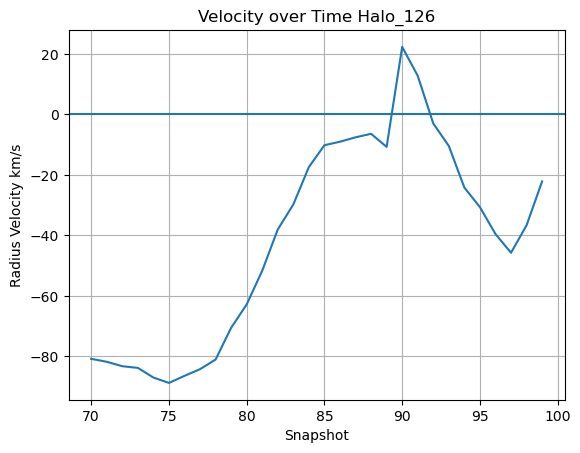

In [42]:
snapshots = np.arange(initial_snapshot, end_snapshot + 1)
plt.plot(snapshots, np.array(satellite_velocity))
plt.xlabel('Snapshot')
plt.ylabel('Radius Velocity km/s')
plt.title('Velocity over Time Halo_126')
plt.grid()
plt.axhline()
plt.show()


In [ ]:
np.load()


: 